Here I demonstrate solving linear regression problem with breakpoints using a hybrid of Ridge and BIC minimization on synthetic data.

*Setting*
We're in an online OLS setting $y \sim N(Xb + \mu, \sigma)$ where $y \in R^n$, $X \in R^{n \times p}$ and $b \in R^p$. The data comes in chunks, with $c_i$ representing the set of samples in chunk $i$, and the true "inferrables" ($b, \mu$ and $\sigma$) can change from chunk to chunk in a jump-like fashion.

*Proposed solution*
I suggest to do the following on a rolling window:
- standardize the features and the response.
- fit an `ElasticNet` (read: or `Lasso` or `Ridge`) on all the chunks.
- put breakpoints using BIC minimization:
    - a breakpoint is when either one of $\hat{b}, \hat\mu, \hat\sigma$ jumps;
    - putting a breakpoint can mean increasing the number of parameters, but may also decrease the NLL (negative log-likelihood), and certain insertions of a breakpoint may result in a `BIC` drop;
    - I put a limit on how frequently one can put down a breakpoint;
    - the problem of finding an optimal `BIC` is solved approximately, via an iterative grid search (iterative referring splitting intervals and redoing the split on subintervals).
    - following the split, the features are augmented with dummy variables for each interval.
    - to predict for the upcoming chunk, I use the coefficients which correspond to the interval after the very last break.
The target metric is NLL, and I'll generate a validation split with novel synthetic data (i.e. true parameters are far from the center of the params used to tune hyperparams), to see how well the fitting strategy works. (*It works - see the plots at the bottom of the page.*)

*Synthetic data*
- For simplicity, I let $p=2$ and $b_2=0$, i.e. $y$ only depends on the first column of $X$.
- I set a total of $100$ chunks for hyperparam fitting, and $50$ for validation, each with $200$ observations.
- The data $X$ is sampled from normal distribution.
- I put in breaks for $b, \mu, \sigma$ "manually"; see the plots below.

In [3]:
from notes.notebooks import *

In [5]:
p = 2
n_chunks_tune = 100
n_chunks_validate = 50
nobs_per_chunk = 200
x_diff_steps = 400
n_tune = n_chunks_tune * nobs_per_chunk
n_validate = n_chunks_validate * nobs_per_chunk
n_chunks = n_chunks_tune + n_chunks_validate
n = n_tune + n_validate
mu = np.repeat(
    np.r_[
        np.repeat([0.1, 0.2, 0.1, -0.1, 0.1, 0.1, 0.4, 0.1, -0.1, 0.1], 10),  # tune
        np.repeat([0.3, 0.6, -0.2, 0.1, 0], 10),  # validate
    ],
    nobs_per_chunk,
)
index = np.linspace(0, n_chunks_tune + n_chunks_validate, n + 1)[1:]
b = np.repeat(
    np.r_[
        np.repeat([0.6, 0.6, 0.3, 0.3, 0.3, 0.8, 0.8, 0.8, 0.6, 0.6], 10),
        np.repeat([0.4, -0.1, -0.1, -0.1, 0.4], 10),
    ],
    nobs_per_chunk,
)
sigma = np.repeat(
    np.r_[
        np.repeat([0.5, 0.6], 50),
        np.repeat([0.5] * 5 + [0.7] * 5, 5),
    ],
    nobs_per_chunk,
)


def generate_data(seed=1):
    np.random.seed(seed)
    x = np.random.randn(n, p)
    y_no_noise = x[:, 0] * b + mu
    y = y_no_noise + sigma * np.random.randn(n)
    return x, y, y_no_noise


x, y, y_no_noise = generate_data()

In [6]:
n_chunks_window = 25


def gen_splits(n_chunks, n_chunks_window, n_gap: int = 1):
    for train_start in range(n_chunks - n_chunks_window - n_gap):
        yield slice(
            nobs_per_chunk * train_start,
            nobs_per_chunk * (train_start + n_chunks_window),
        ), slice(
            nobs_per_chunk * (train_start + n_chunks_window + n_gap),
            nobs_per_chunk * (train_start + n_chunks_window + n_gap + 1),
        )

In [7]:
# benchmark model 1: OLS.
# each model we consider can `fit` (after which it gets `coef_`, `intercept_` and `scale_` - inferred sample noise) and `predict`
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


class FitterWithNormalize(Pipeline):
    def __init__(self, *, base_model):
        super().__init__(steps=[("scaler", StandardScaler()), ("base", base_model)])
        self.base_model = base_model
        self.coef_, self.intercept_, self.scale_ = None, None, None

    def fit(self, x, y, *, sample_weight=None):
        super().fit(x, y, base__sample_weight=sample_weight)
        self.coef_ = self.steps[1][1].coef_ / self.steps[0][1].scale_
        self.intercept_ = (
            self.steps[1][1].intercept_ - self.coef_ @ self.steps[0][1].mean_
        )
        if sample_weight is None:
            self.scale_ = np.std(y - self.predict(x))
        else:
            self.scale_ = np.sqrt(
                (sample_weight @ (y - self.predict(x)) ** 2) / sample_weight.sum()
            )

    def predict(self, x):
        return x @ self.coef_ + self.intercept_

    def nll(self, x, y, sample_weight=None):
        elements = 2 * np.log(self.scale_) + (
            ((self.predict(x) - y) / self.scale_) ** 2
        )
        if sample_weight is None:
            return np.mean(elements)
        else:
            return (elements @ sample_weight) / sample_weight.sum()


def evaluate_model(model, with_validation):
    fits, stds, nlls, coefs, intercepts = [], [], [], [], []
    n_split = n_chunks_tune
    if with_validation:
        n_split += n_chunks_validate
    for train, test in gen_splits(n_split, n_chunks_window):
        xtrain = x[train]
        ytrain = y[train]
        xtest = x[test]
        ytest = y[test]
        model.fit(xtrain, ytrain)
        ytest_hat = model.predict(xtest)
        fits.append(ytest_hat)
        stds.append(model.scale_)
        coefs.append(model.coef_)
        intercepts.append(model.intercept_)
        fit_nll = model.nll(xtest, ytest)
        true_nll = 2 * np.log(sigma[test]).mean() + (
            ((y_no_noise[test] - ytest) / sigma[test]) ** 2
        ).mean(axis=0)
        nlls.append(fit_nll - true_nll)  # log-likelihood loss
    return {
        "fits": np.concatenate(fits),
        "stds": np.array(stds),
        "coefs": np.vstack(coefs),
        "intercepts": np.array(intercepts),
        "nlls": np.array(nlls),
    }


ols_evaluation = evaluate_model(
    FitterWithNormalize(base_model=LinearRegression(fit_intercept=True)),
    with_validation=True,
)

In [8]:
# benchmark 2: tuned Ridge (started with ElasticNet, but ended up with Ridge after a grid search)
# it ends up being essentially identical to the OLS
from sklearn.linear_model import Ridge

alpha = np.exp(-5.5)
ridge_evaluation = evaluate_model(
    FitterWithNormalize(
        base_model=Ridge(
            fit_intercept=True, alpha=alpha * nobs_per_chunk * n_chunks_window
        ),
    ),
    with_validation=True,
)

In [9]:
# actual model
from notes.ml import regime_change

model = regime_change.RidgeWithChange(
    alpha=np.exp(-5.5), min_obs_before_break=nobs_per_chunk, nintervals_per_iteration=16
)
model.fit(x, y)

In [11]:
# the code below essentially shows that we can pick a very small ridge penalty;
# the only reason we need to pick it at all is perfect collinearity in the features

# def nll_score(logalpha):
#     return evaluate_model(
#         regime_change.RidgeWithChange(
#             alpha=np.exp(logalpha),
#             min_obs_before_break=nobs_per_chunk,
#             nintervals_per_iteration=16,
#         ),
#         with_validation=False,
#     )["nlls"].mean()

# logalphas = np.linspace(-30, 0, 11)
# plt.plot(logalphas, [nll_score(la) for la in logalphas])

In [12]:
change_model_evaluation = evaluate_model(
    regime_change.RidgeWithChange(
        alpha=np.exp(-10),  # any number that is small, but not too small
        min_obs_before_break=nobs_per_chunk,
        nintervals_per_iteration=16,
    ),
    with_validation=True,
)

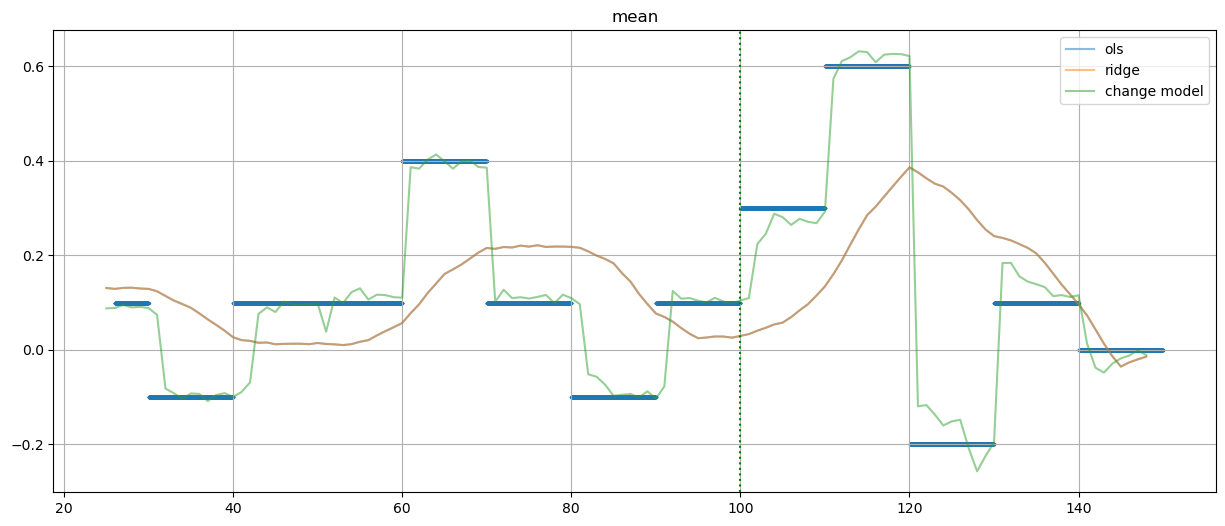

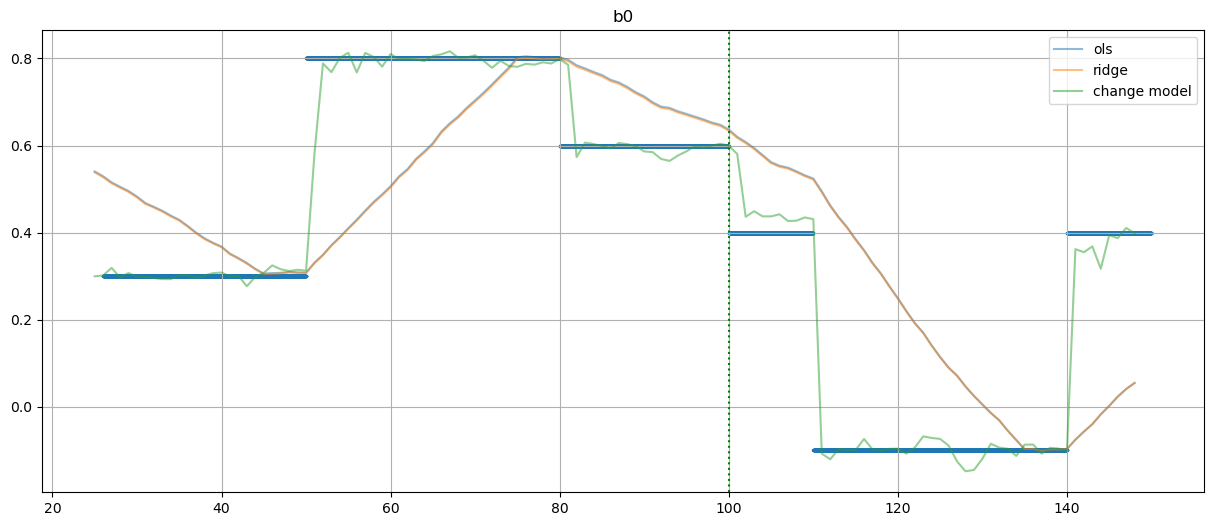

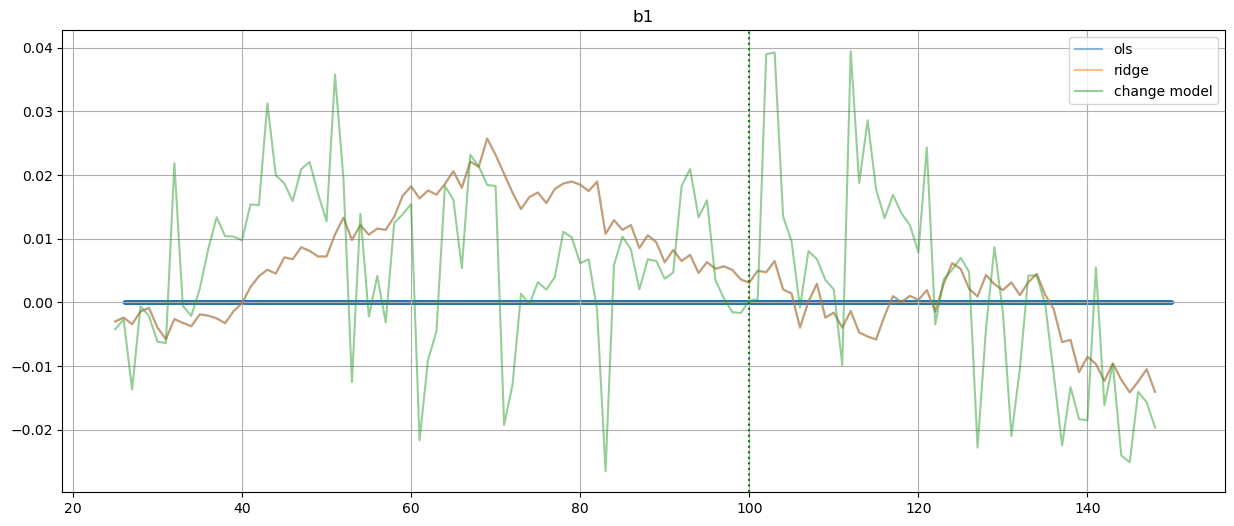

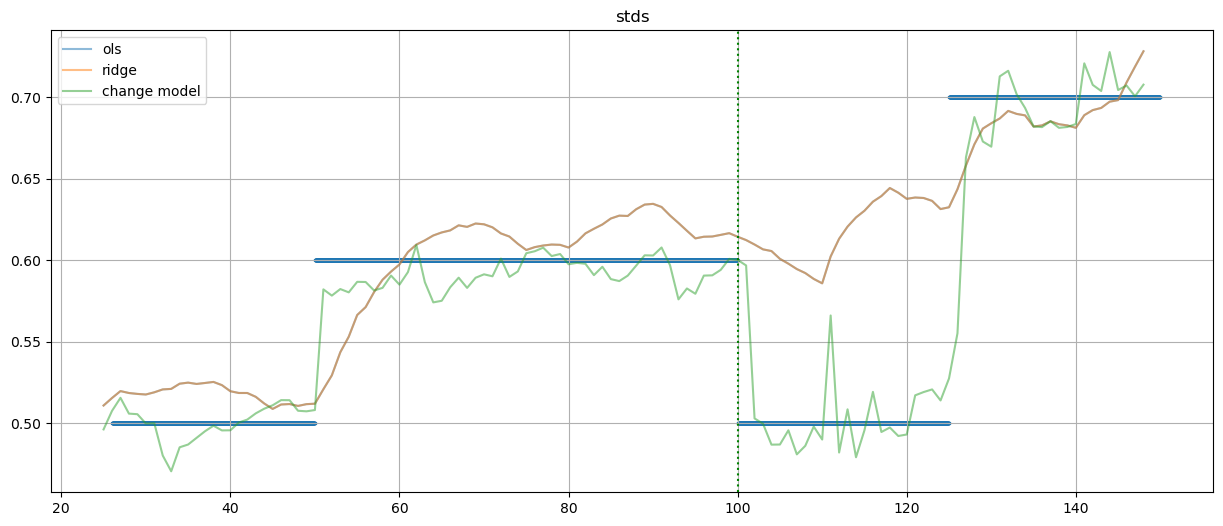

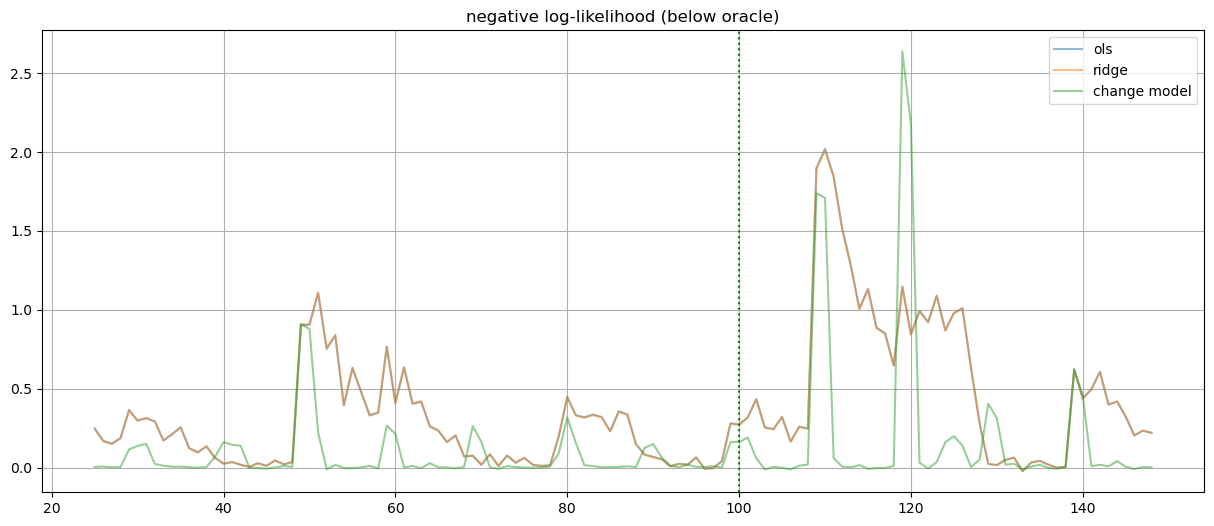

mean log-likelihood below oracle


,ols,ridge,change_model
in sample,0.233985,0.233973,0.066895
out of sample,0.576770,0.575062,0.229106


In [13]:
# we see that the change model is superior to simple ridge/OLS
for label, (true, ridge_fit, ols_fit, change_fit) in {
    "mean": (
        mu,
        ridge_evaluation["intercepts"],
        ols_evaluation["intercepts"],
        change_model_evaluation["intercepts"],
    ),
    "b0": (
        b,
        ridge_evaluation["coefs"][:, 0],
        ols_evaluation["coefs"][:, 0],
        change_model_evaluation["coefs"][:, 0],
    ),
    "b1": (
        np.zeros_like(b),
        ridge_evaluation["coefs"][:, 1],
        ols_evaluation["coefs"][:, 1],
        change_model_evaluation["coefs"][:, 1],
    ),
    "stds": (
        sigma,
        ridge_evaluation["stds"],
        ols_evaluation["stds"],
        change_model_evaluation["stds"],
    ),
    "llf": (
        None,
        ridge_evaluation["nlls"],
        ols_evaluation["nlls"],
        change_model_evaluation["nlls"],
    ),
}.items():
    plt.figure(figsize=(15, 6))
    if true is not None:
        plt.scatter(
            index[(n_chunks_window + 1) * nobs_per_chunk :],
            true[(n_chunks_window + 1) * nobs_per_chunk :],
            s=2.0,
            alpha=0.5,
        )
    for f, l in [(ols_fit, "ols"), (ridge_fit, "ridge"), (change_fit, "change model")]:
        plt.plot(np.arange(n_chunks_window, n_chunks - 1), f, label=l, alpha=0.5)
    plt.title(label if label != "llf" else f"negative log-likelihood (below oracle)")
    plt.axvline(n_chunks_tune, linestyle="dotted", color="green")
    plt.grid()
    plt.legend()
    plt.show()
print("mean log-likelihood below oracle")
display(
    pd.DataFrame.from_dict(
        {
            k: {
                "in sample": data["nlls"][:-n_chunks_validate].mean(),
                "out of sample": data["nlls"][-n_chunks_validate:].mean(),
            }
            for k, data in {
                "ols": ols_evaluation,
                "ridge": ridge_evaluation,
                "change_model": change_model_evaluation,
            }.items()
        }
    )
)